In [1]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import itertools
import gymnasium
import mountain_lite

In [2]:
np.random.seed(0)
random.seed(0)

In [3]:
with open('trajectories.pickle', 'rb') as fd:
    D = pickle.load(fd)

In [4]:
env = gymnasium.make('mountain_lite/GridWorld-v0')

In [5]:
def plot_trajectory(env, trajectory, title=""):
    custom_cmap = sns.cubehelix_palette(start=.5, rot=-.5, reverse=True, as_cmap=True)
    plt.figure(figsize=(11, 3))
    sns.heatmap(env.unwrapped.MAP, cmap=custom_cmap, linewidths=0.5, linecolor='slategrey')

    trajectory = np.array(trajectory)
    plt.plot(trajectory[:, 1] + 0.5, trajectory[:, 0] + 0.5, color='azure', marker='.')
    plt.title(title)
    plt.xticks(ticks=[*range(0, 101, 10)], labels=[*range(0, 101, 10)])
    plt.yticks(ticks=[*range(0, 31, 10)], labels=[*range(0, 31, 10)])

    plt.show()

In [6]:
def get_trajectory(env, Q=None, policy=None):
    state, _ = env.reset()
    trajectory = [get_pos(state)]
    trajectory_length = 0

    while True:
        if Q is not None:
            action = np.argmax(Q[get_pos(state)])
        if policy is not None:
            action = np.argmax(policy(get_pos(state)))
        state, reward, done, _, _ = env.step(action)
        trajectory_length += 1
        trajectory.append(get_pos(state))
        if done or trajectory_length > 500:
            break

    return trajectory

1. Load the trajectories and perform MC evaluation for $v_\pi(s)$.

In [7]:
def mc_prediction(trajectories, gamma=1, env_height=31, env_width=100):
    # initialize value function to zero for all states
    V = np.zeros((env_height, env_width))
    # initialize returns to an empty list for all states
    returns = {(i, j): [] for i in range(env_height) for j in range(env_width)}

    # process each trajectory
    for i, trajectory in enumerate(trajectories):
        G = 0
        states_and_returns = []

        # reverse trajectory to calculate returns from the end
        for state, _, reward, _ in reversed(trajectory):
            G = gamma * G + reward
            states_and_returns.append((state, G))

        # track visited states for first-visit MC
        states_visited = set()

        # update value function for states, but only for first visit
        for state, G in reversed(states_and_returns):
            if state not in states_visited:
                returns[state].append(G)
                V[state] = np.mean(returns[state])
                states_visited.add(state)

    return V

In [8]:
value_function = mc_prediction(D)

2. Load the trajectories and perform MC evaluation for $q_\pi(a,s)$.

In [9]:
def mc_action_value_prediction(trajectories, gamma=1, env_height=31, env_width=100, action_space=8):
    # initialize action-value function to zero for all state-action pairs
    Q = np.zeros((env_height, env_width, action_space))
    # initialize a dictionary to store returns for all state-action pairs
    returns = {(i, j, a): [] for i in range(env_height) for j in range(env_width) for a in range(action_space)}

    # process each trajectory
    for trajectory in trajectories:
        G = 0  # discounted return
        state_action_returns = []

        # reverse trajectory to calculate returns from the end
        for state, action, reward, _ in reversed(trajectory):
            G = gamma * G + reward
            state_action_returns.append((state, action, G))

        # track visited state-action pairs for first-visit MC
        state_action_visited = set()

        # update action-value function for state-action pairs, but only for first visit
        for state, action, G in reversed(state_action_returns):
            if (state, action) not in state_action_visited:
                returns[(state[0], state[1], action)].append(G)
                # update Q value as average of returns for this state-action pair
                Q[state[0], state[1], action] = np.mean(returns[(state[0], state[1], action)])
                state_action_visited.add((state, action))

    return Q

In [10]:
action_value_function = mc_action_value_prediction(D)

3. Plot the state-value function $v_\pi(s)$.

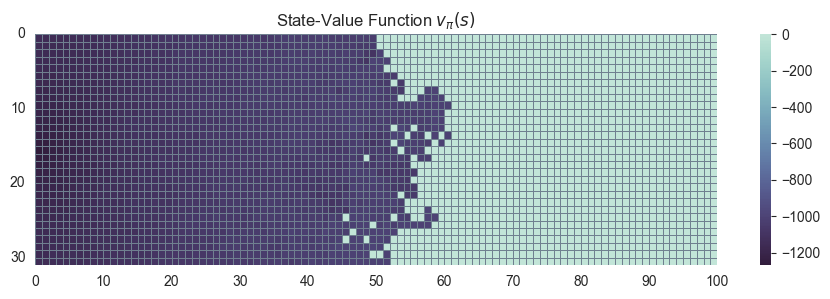

In [11]:
custom_cmap = sns.cubehelix_palette(start=.5, rot=-.5, reverse=True, as_cmap=True)
plt.figure(figsize=(11, 3))
sns.heatmap(value_function, cmap=custom_cmap, linewidths=0.5, linecolor='slategrey')
plt.title('State-Value Function $v_\pi(s)$')
plt.xticks(ticks=[*range(0, 101, 10)], labels=[*range(0, 101, 10)])
plt.yticks(ticks=[*range(0, 31, 10)], labels=[*range(0, 31, 10)])
plt.show()

5. (*) Can you perform MC improvement? If so, perform it and explain whether the new policy is optimal or not.

In [12]:
def mc_policy_improvement(Q):
    new_policy = np.argmax(Q, axis=2)
    return new_policy

In [13]:
mc_policy_improvement(action_value_function)

array([[2, 6, 2, ..., 0, 0, 0],
       [4, 5, 6, ..., 0, 0, 0],
       [4, 6, 6, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [3, 3, 4, ..., 0, 0, 0],
       [3, 7, 5, ..., 0, 0, 0]])

7. (*) Choose a starting policy for the robot, and justify your choice.

In [14]:
def random_argmax(arr):
    max_value = np.max(arr)
    max_indices = np.where(arr == max_value)[0]
    random_index = random.choice(max_indices)
    return random_index

In [15]:
def eps_greedy_policy(Q, epsilon, action_space):
    # define an epsilon-greedy policy function based on Q table
    def policy_func(state):
        # initialize a uniform distribution for all actions with a bias of epsilon
        prob_distribution = np.ones(action_space) * epsilon / action_space
        # use random_argmax to choose action with the highest Q value (with ties broken arbitrarily)
        best_action = random_argmax(Q[state])
        # increase probability of taking the best action by 1 - epsilon
        prob_distribution[best_action] += (1 - epsilon)
        return prob_distribution

    return policy_func

8. Perform MC control and learn an optimal policy for the robot.

In [16]:
def get_pos(state):
    return tuple(state["agent"]["pos"])

In [17]:
def mc_control_epsilon_greedy(env, num_episodes, epsilon=0.8, gamma=1, env_height=31, env_width=100):
    # initialize Q table with zeros for storing action-value function
    # Q = np.zeros((env_height, env_width, env.action_space.n))
    # reuse action-value function from task 2
    Q = np.copy(action_value_function)
    # initialize policy using epsilon-greedy method
    policy = eps_greedy_policy(Q, epsilon, env.action_space.n)
    # initialize a dictionary to store returns for all state-action pairs
    returns = {(i, j, a): [] for i in range(env_height) for j in range(env_width) for a in range(env.action_space.n)}

    stats = {"episode_length": [],
             "episode_reward": []}

    # loop through each episode
    for i in range(1, num_episodes + 1):
        if i % 100 == 0:
            print(f"\rEpisode {i}/{num_episodes}.", end="")

        # initialize an empty trajectory for current episode
        trajectory = []
        episode_length, episode_reward = 0, 0
        # reset environment and get initial state
        state, _ = env.reset()
        # generate an episode following policy
        while True:
            # get action probabilities from policy
            probs = policy(get_pos(state))
            # choose an action based on policy
            action = np.random.choice(np.arange(len(probs)), p=probs)
            # take action in environment
            next_state, reward, done, _, _ = env.step(action)
            # append experience to trajectory
            trajectory.append((get_pos(state), action, reward))

            episode_length += 1
            episode_reward += reward
            if done:
                stats["episode_length"].append(episode_length)
                stats["episode_reward"].append(episode_reward)
                break  # exit loop if agent has reached target

            # update state
            state = next_state

        # plot_trajectory([t[0] for t in trajectory])

        G = 0  # return
        state_action_returns = []  # returns for each state-action pair in episode
        for state, action, reward in reversed(trajectory):
            # update return using reward and discount factor
            G = gamma * G + reward
            state_action_returns.append((state, action, G))

        # track visited state-action pairs to ensure first-visit MC
        state_action_visited = set()

        # update Q values for first-visit state-action pairs in episode
        for state, action, G in reversed(state_action_returns):
            if (state, action) not in state_action_visited:
                returns[(state[0], state[1], action)].append(G)
                # update Q value as average of returns for this state-action pair
                Q[state[0], state[1], action] = np.mean(returns[(state[0], state[1], action)])
                state_action_visited.add((state, action))  # mark state-action pair as visited

    return policy, stats

In [19]:
mc_control_policy, mc_control_stats = mc_control_epsilon_greedy(env, num_episodes=5000)

Episode 5000/5000.

In [98]:
mc_control_trajectory = get_trajectory(env, policy=mc_control_policy)

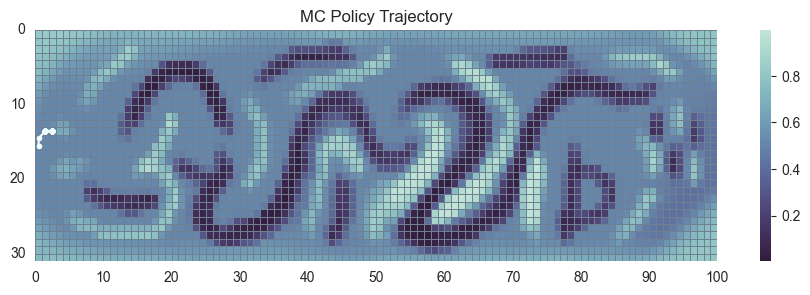

In [99]:
plot_trajectory(env, mc_control_trajectory, title="MC Policy Trajectory")

10. Implement SARSA(0) and use it to learn an optimal policy for the robot.

In [37]:
def sarsa_0(env, num_episodes, epsilon=0.8, gamma=1, alpha=0.1):
    # reuse action-value function from task 2 (Q(terminal,·) = 0)
    Q = np.copy(action_value_function)

    # initialize policy using epsilon-greedy method
    policy = eps_greedy_policy(Q, epsilon, env.action_space.n)

    stats = {"episode_length": [],
             "episode_reward": []}

    for i in range(1, num_episodes + 1):
        if i % 100 == 0:
            print(f"\rEpisode {i}/{num_episodes}.", end="")

        episode_length, episode_reward = 0, 0

        # initialize S
        state, _ = env.reset()
        probs = policy(get_pos(state))
        # choose A from S using eps-greedy policy derived from Q
        action = np.random.choice(np.arange(len(probs)), p=probs)

        # loop for each step of episode until S is terminal
        while True:
            # take action A, observe R, S'
            next_state, reward, done, _, _ = env.step(action)

            # choose A' from S' using eps-greedy policy derived from Q
            next_state_probs = policy(get_pos(next_state))
            next_action = np.random.choice(np.arange(len(next_state_probs)), p=next_state_probs)

            # SARSA update
            td_target = reward + gamma * Q[get_pos(next_state)][next_action]
            td_delta = td_target - Q[get_pos(state)][action]
            Q[get_pos(state)][action] += alpha * td_delta

            episode_length += 1
            episode_reward += reward
            if done:
                stats["episode_length"].append(episode_length)
                stats["episode_reward"].append(episode_reward)
                break  # exit loop if agent has reached target

            # update state and action
            state = next_state
            action = next_action

    return Q, stats

In [38]:
sarsa0_Q, sarsa0_stats = sarsa_0(env, num_episodes=5000, epsilon=0.8)

Episode 5000/5000.

In [100]:
sarsa0_trajectory = get_trajectory(env, Q=sarsa0_Q)

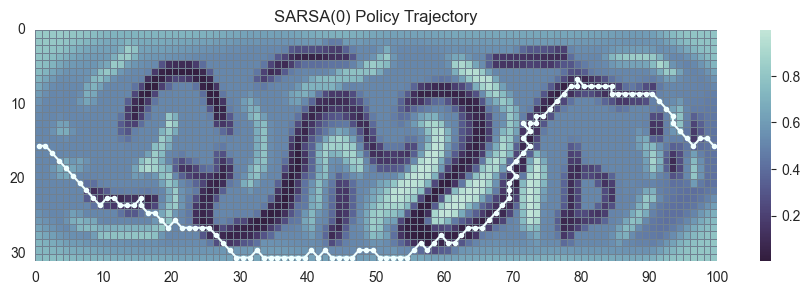

In [101]:
plot_trajectory(env, sarsa0_trajectory, title="SARSA(0) Policy Trajectory")

12. Implement SARSA(n) and use it to learn an optimal policy for the robot, considering at least three different values for n.

In [70]:
def sarsa_n(env, num_episodes, n, epsilon=0.8, alpha=0.1, gamma=1):
    # reuse action-value function from task 2
    Q = np.copy(action_value_function)

    # initialize policy using epsilon-greedy method
    policy = eps_greedy_policy(Q, epsilon, env.action_space.n)

    stats = {"episode_length": [],
             "episode_reward": []}

    for episode in range(1, num_episodes + 1):
        if episode % 100 == 0:
            print(f"\rEpisode {episode}/{num_episodes}.", end="")

        episode_length, episode_reward = 0, 0

        # initialize and store S_0 != terminal
        state, _ = env.reset()
        probs = policy(get_pos(state))
        action = np.random.choice(np.arange(len(probs)), p=probs)

        # lists to store states, actions, and rewards
        states = [state]
        actions = [action]
        rewards = [0]  # reward for the initial state is 0

        T = float('inf')
        t = 0

        while True:
            if t < T:
                # take action A_t
                next_state, reward, done, _, _ = env.step(action)

                episode_length += 1
                episode_reward += reward

                # store the next reward as R_t+1 and the next state as S_t+1
                rewards.append(reward)
                states.append(next_state)

                # if S_t+1 is terminal
                if done:
                    T = t + 1
                else:
                    # select and store an action A_{t+1} ~ π(.|S_t+1)
                    probs = policy(get_pos(next_state))
                    next_action = np.random.choice(np.arange(env.action_space.n), p=probs)
                    actions.append(next_action)

            # τ is the time whose estimate is being updated
            tau = t - n + 1
            if tau >= 0:
                G = np.sum([gamma ** (i - tau - 1) * rewards[i] for i in range(tau + 1, min(tau + n, T) + 1)])

                if tau + n < T:
                    G += gamma ** n * Q[get_pos(states[tau + n])][actions[tau + n]]

                # state and action at time τ
                s_tau, a_tau = get_pos(states[tau]), actions[tau]
                Q[s_tau][a_tau] += alpha * (G - Q[s_tau][a_tau])

            if tau == T - 1:
                stats["episode_length"].append(episode_length)
                stats["episode_reward"].append(episode_reward)
                break

            t += 1
            # set up the next action
            if t < T:
                action = actions[t]

    return Q, stats

In [71]:
sarsa3_Q, sarsa3_stats = sarsa_n(env, n=3, num_episodes=5000)

Episode 5000/5000.

In [75]:
sarsa5_Q, sarsa5_stats = sarsa_n(env, n=5, num_episodes=5000)

Episode 5000/5000.

In [86]:
sarsa10_Q, sarsa10_stats = sarsa_n(env, n=10, num_episodes=5000)

Episode 5000/5000.

In [73]:
sarsa3_trajectory = get_trajectory(env, Q=sarsa3_Q)

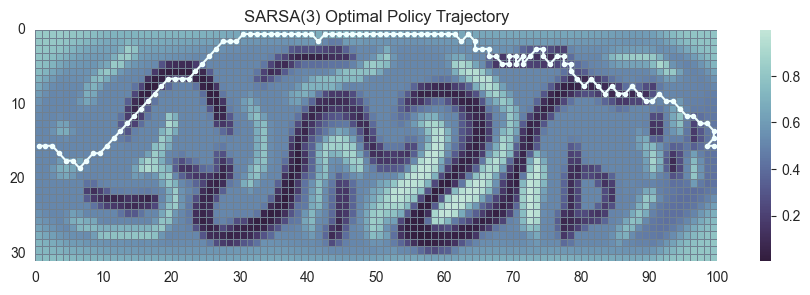

In [74]:
plot_trajectory(env, sarsa3_trajectory, title="SARSA(3) Policy Trajectory")

In [84]:
sarsa5_trajectory = get_trajectory(env, Q=sarsa5_Q)

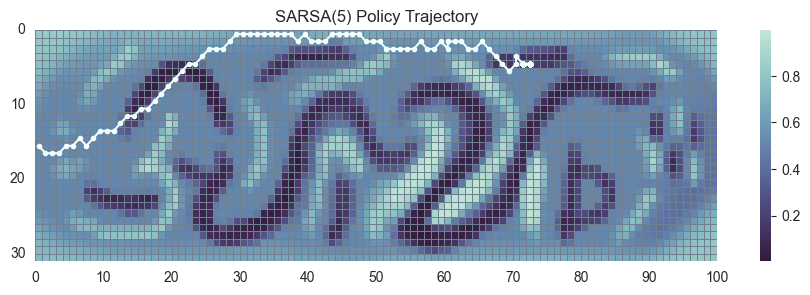

In [85]:
plot_trajectory(env, sarsa5_trajectory, title="SARSA(5) Policy Trajectory")

In [91]:
sarsa10_trajectory = get_trajectory(env, Q=sarsa10_Q)

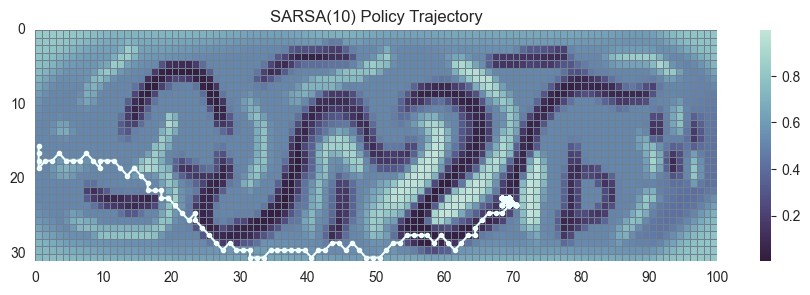

In [92]:
plot_trajectory(env, sarsa10_trajectory, title="SARSA(10) Policy Trajectory")

14. Implement Q-learning and use it to learn an optimal policy for the robot.

In [42]:
def q_learning(env, num_episodes, epsilon=0.8, gamma=1, alpha=0.1):
    # reuse action-value function from task 2 (Q(terminal,·) = 0)
    Q = np.copy(action_value_function)

    # initialize policy using epsilon-greedy method
    policy = eps_greedy_policy(Q, epsilon, env.action_space.n)

    stats = {"episode_length": [],
             "episode_reward": []}

    for i in range(1, num_episodes + 1):
        if i % 100 == 0:
            print(f"\rEpisode {i}/{num_episodes}.", end="")

        episode_length, episode_reward = 0, 0

        # initialize S
        state, _ = env.reset()

        # loop for each step of episode until S is terminal
        while True:
            probs = policy(get_pos(state))
            # choose A from S using eps-greedy policy derived from Q
            action = np.random.choice(np.arange(len(probs)), p=probs)

            # take action A, observe R, S'
            next_state, reward, done, _, _ = env.step(action)

            # Q-learning update
            best_next_action = np.argmax(Q[get_pos(next_state)])
            td_target = reward + gamma * Q[get_pos(next_state)][best_next_action]
            td_delta = td_target - Q[get_pos(state)][action]
            Q[get_pos(state)][action] += alpha * td_delta

            episode_length += 1
            episode_reward += reward
            if done:
                stats["episode_length"].append(episode_length)
                stats["episode_reward"].append(episode_reward)
                break  # exit loop if agent has reached target

            # update state
            state = next_state

    return policy, stats

In [43]:
q_learning_policy, q_learning_stats = q_learning(env, num_episodes=5000)

Episode 5000/5000.

In [44]:
q_learning_trajectory = get_trajectory(env, policy=q_learning_policy)

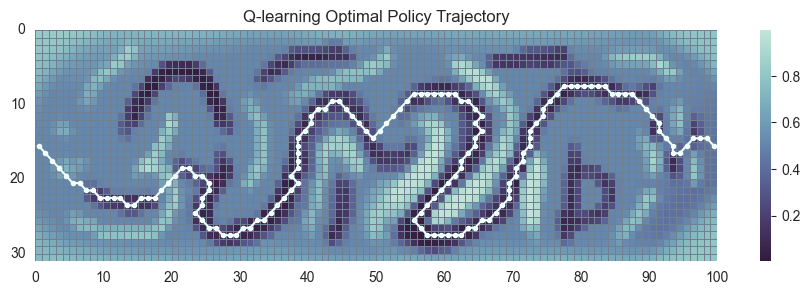

In [45]:
plot_trajectory(env, q_learning_trajectory, title="Q-learning Policy Trajectory")

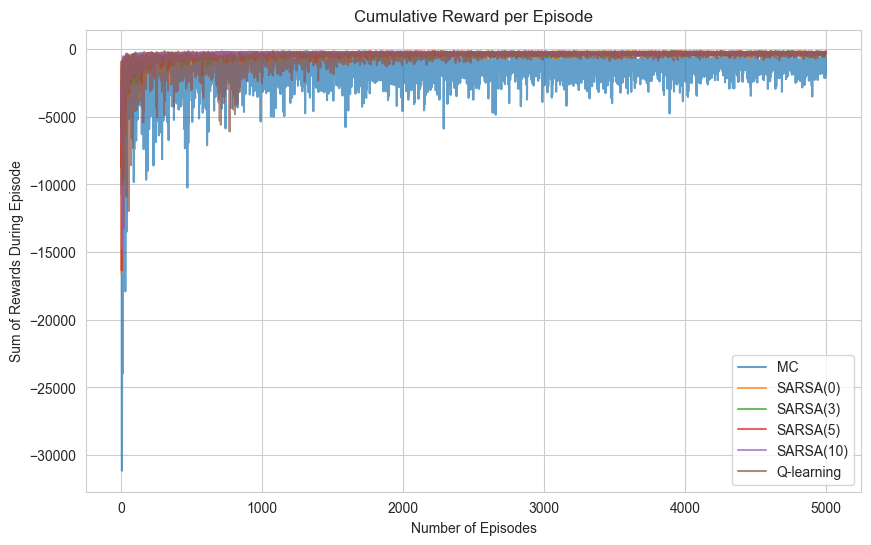

In [93]:
plt.figure(figsize=(10, 6))
plt.plot(mc_control_stats["episode_reward"], label="MC", alpha=0.7)
plt.plot(sarsa0_stats["episode_reward"], label="SARSA(0)", alpha=0.7)
plt.plot(sarsa3_stats["episode_reward"], label="SARSA(3)", alpha=0.7)
plt.plot(sarsa5_stats["episode_reward"], label="SARSA(5)", alpha=0.7)
plt.plot(sarsa10_stats["episode_reward"], label="SARSA(10)", alpha=0.7)
plt.plot(q_learning_stats["episode_reward"], label="Q-learning", alpha=0.7)
plt.title("Cumulative Reward per Episode")
plt.xlabel("Number of Episodes")
plt.ylabel("Sum of Rewards During Episode")
plt.legend()
plt.show()

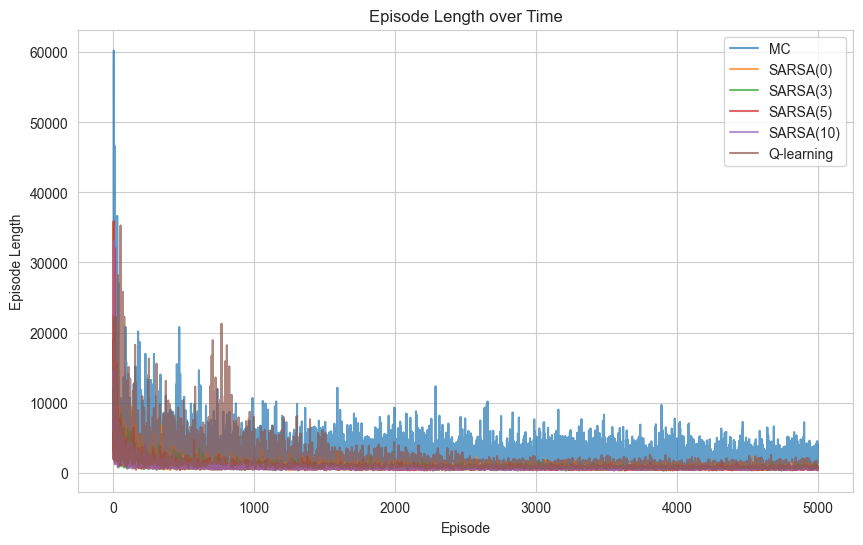

In [94]:
plt.figure(figsize=(10, 6))
plt.plot(mc_control_stats["episode_length"], label="MC", alpha=0.7)
plt.plot(sarsa0_stats["episode_length"], label="SARSA(0)", alpha=0.7)
plt.plot(sarsa3_stats["episode_length"], label="SARSA(3)", alpha=0.7)
plt.plot(sarsa5_stats["episode_length"], label="SARSA(5)", alpha=0.7)
plt.plot(sarsa10_stats["episode_length"], label="SARSA(10)", alpha=0.7)
plt.plot(q_learning_stats["episode_length"], label="Q-learning", alpha=0.7)
plt.title("Episode Length over Time")
plt.xlabel("Episode")
plt.ylabel("Episode Length")
plt.legend()
plt.show()

In [97]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

fig = make_subplots()

fig.add_trace(
    go.Scatter(x=np.arange(len(mc_control_stats["episode_reward"])), y=mc_control_stats["episode_reward"], name='MC'))
fig.add_trace(
    go.Scatter(x=np.arange(len(sarsa0_stats["episode_reward"])), y=sarsa0_stats["episode_reward"], name='SARSA(0)'))
fig.add_trace(
    go.Scatter(x=np.arange(len(sarsa3_stats["episode_reward"])), y=sarsa3_stats["episode_reward"], name='SARSA(3)'))
fig.add_trace(
    go.Scatter(x=np.arange(len(sarsa5_stats["episode_reward"])), y=sarsa5_stats["episode_reward"], name='SARSA(5)'))
fig.add_trace(
    go.Scatter(x=np.arange(len(sarsa10_stats["episode_reward"])), y=sarsa10_stats["episode_reward"], name='SARSA(10)'))
fig.add_trace(go.Scatter(x=np.arange(len(q_learning_stats["episode_reward"])), y=q_learning_stats["episode_reward"],
                         name='Q-learning'))

# Add figure title and axis labels
fig.update_layout(title_text="Cumulative Reward per Episode",
                  xaxis_title="Number of Episodes",
                  yaxis_title="Sum of Rewards During Episode")

# Set x-axis and y-axis ranges if necessary (optional)
fig.update_xaxes(range=[-100, 5100])
# fig.update_yaxes(range=[-50000, 0])

# Show the plot
fig.show()